In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
# folders paths
train_path = "C:/Users/WeixiLi/Desktop/Broccoli/train"
test_path = "C:/Users/WeixiLi/Desktop/Broccoli/test"

In [3]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  vertical_flip = True,
                  validation_split=0.2, # training: 80% data, validation: 20% data
                  brightness_range=[0.2,1.0]
                 )
 
train_generator = gen.flow_from_directory(
    #labels, # dataframe
    #directory = 
    train_path, # images data path / folder in which images are there
    #x_col = 'id',
    #y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (224,224), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)
 
validation_generator = gen.flow_from_directory(
    #labels, # dataframe
    #directory = 
    train_path, # images data path / folder in which images are there
    #x_col = 'id',
    #y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (224,224), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)

Found 567 images belonging to 4 classes.
Found 141 images belonging to 4 classes.


In [4]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 1
1 : 2
2 : 3
3 : 4


In [5]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [6]:
for layer in pre_trained_model.layers:
    print(layer.name)
layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [7]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

In [8]:
model = tf.keras.Model(pre_trained_model.input, x)

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [10]:
vgg_classifier = model.fit(train_generator,
steps_per_epoch=(497//64),
epochs = 5,
validation_data=validation_generator,
validation_steps=(123//64),
batch_size = 64,
verbose = 1)

Epoch 1/5
7/7 [==============================] - 511s 72s/step - loss: 1.7496 - acc: 0.4305 - val_loss: 1.1657 - val_acc: 0.4531
Epoch 2/5
7/7 [==============================] - 563s 81s/step - loss: 1.2103 - acc: 0.4328 - val_loss: 0.9762 - val_acc: 0.5938
Epoch 3/5
7/7 [==============================] - 570s 83s/step - loss: 1.1477 - acc: 0.4621 - val_loss: 1.0069 - val_acc: 0.5625
Epoch 4/5
7/7 [==============================] - 659s 94s/step - loss: 1.1390 - acc: 0.4419 - val_loss: 0.9975 - val_acc: 0.5781
Epoch 5/5
7/7 [==============================] - 1198s 127s/step - loss: 1.1274 - acc: 0.4647 - val_loss: 1.0401 - val_acc: 0.5312


In [11]:
model.save("VGG16_Model.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.46469247341156006\nValidation Accuracy: 0.53125')

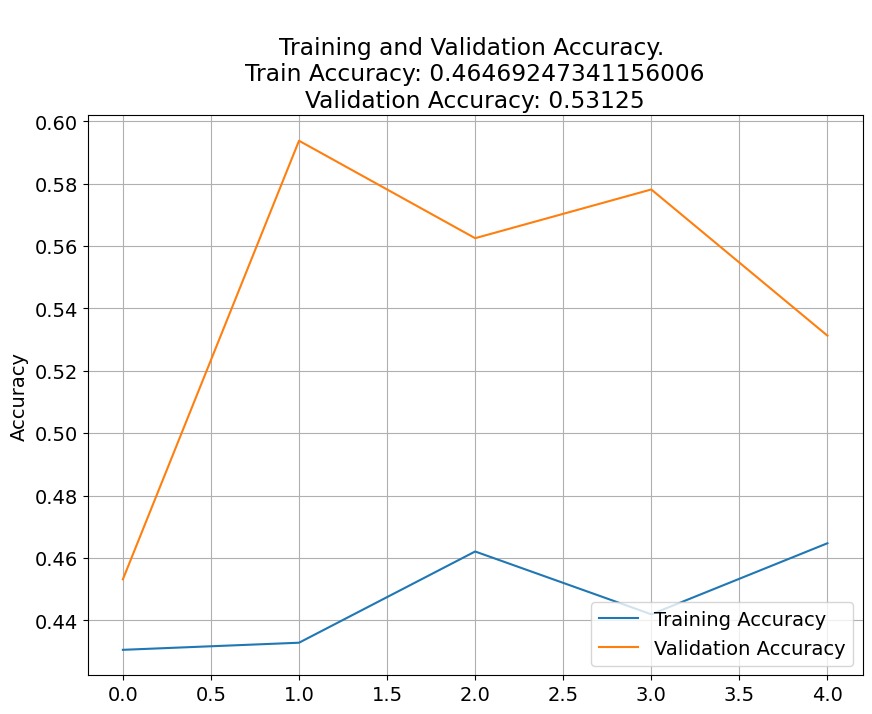

In [12]:
# store results
acc = vgg_classifier.history['acc']
val_acc = vgg_classifier.history['val_acc']
loss = vgg_classifier.history['loss']
val_loss = vgg_classifier.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

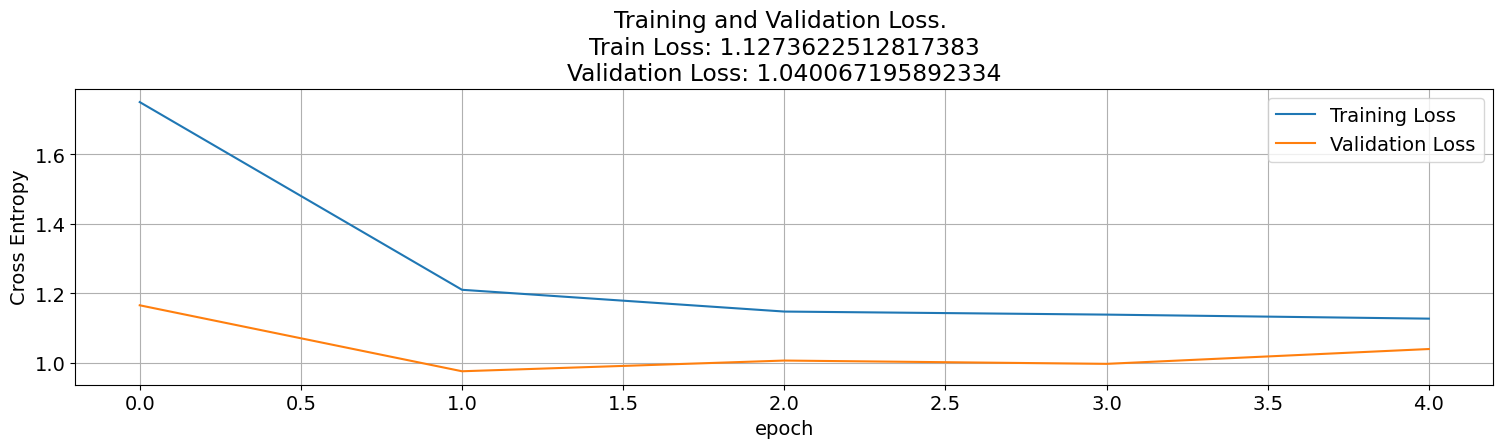

In [13]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [14]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

3/3 [==============================] - 50s 12s/step - loss: 1.0514 - acc: 0.5106
[1.0513564348220825, 0.5106382966041565]
Accuracy: 51.0638%
Loss:  1.0513564348220825


In [15]:
test_datagen = ImageDataGenerator(
                  rescale=1./255.,
                  #horizontal_flip = True,
                  #vertical_flip = True,
                  #validation_split=0.2, # training: 80% data, validation: 20% data
                  #brightness_range=[0.2,1.0]
                 )

test_generator = test_datagen.flow_from_directory(test_path,
                                                 shuffle=False,
                                                 batch_size=64,
                                                 target_size = (240, 320),
                                                 class_mode='categorical')

Found 380 images belonging to 4 classes.


In [16]:
predictions = model.predict(test_generator)

6/6 [==============================] - 205s 33s/step


In [17]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=64)

6/6 [==============================] - 189s 30s/step - loss: 1.0307 - acc: 0.5789


In [18]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.030707597732544
Test Accuracy: 0.5789473652839661


In [19]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

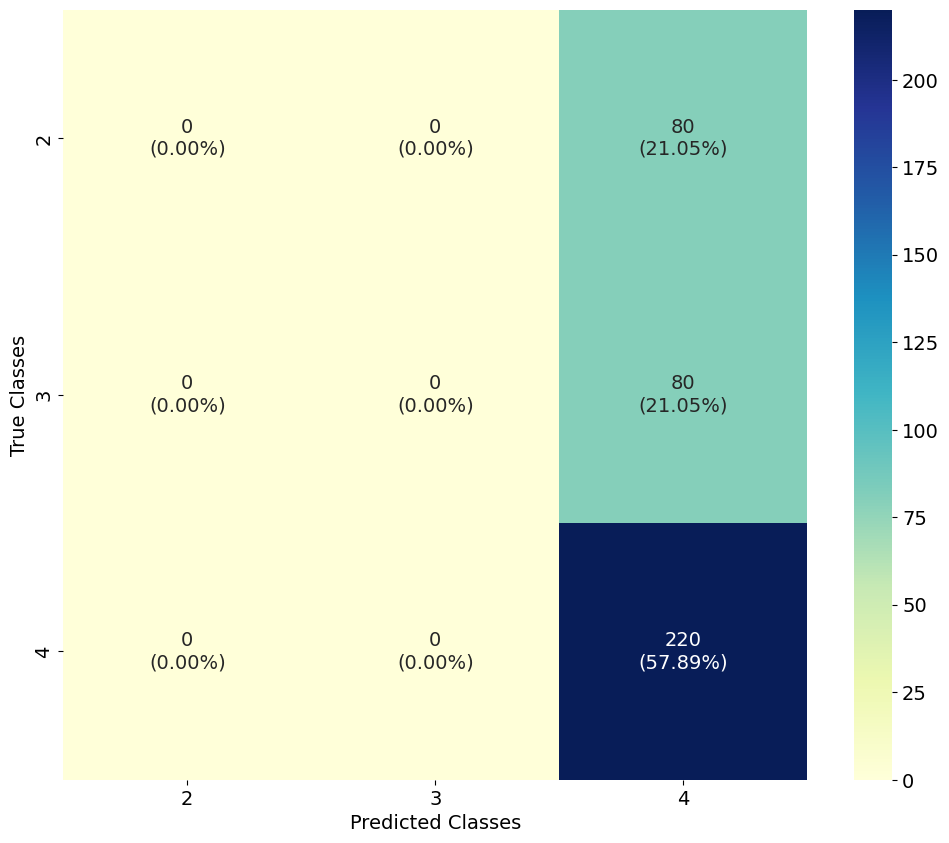

In [20]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(3, 3)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=[2,3,4], yticklabels=[2,3,4],
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()